In [ ]:
# %%
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
import seaborn as sns
import math
from collections import Counter
from functools import reduce
#For interactive plots 

import plotly.graph_objects as go #pip install plotly
import dash
from dash import dcc, html #pip install dash
from dash.dependencies import Input, Output #pip install dash-bootstrap-components

#load the statistical libraries
from statsmodels.stats import diagnostic
from scipy import stats

from src.data.utils import get_franchise_movies, get_franchise_data, get_inflation_rate, get_movie, get_genre_counts, get_1_2_movies


In [335]:
#loading the inflation rate data set from the columbia bank 
inflation_rate_df=get_inflation_rate()

#loading the complete data set 
movies_df_raw = pd.read_csv('data/movie_metadata_with_tmdb.csv')

#loading the data set for the franchise movies 
franchise_df=get_franchise_movies(movies_df_raw,inflation_rate_df,'data/missing_dates_manualsearch.csv')

#Data frame with all the movies with processing
movies_df=get_movie(movies_df_raw,inflation_rate_df)

#Data frame with movies that are not part of a franchise
movies_no_franchise_df = movies_df[movies_df['collection_id'].isna()].reset_index(drop=True)

#Data frame of only the franchise name and their characteristics
franchise_data_df = get_franchise_data(franchise_df)

# Drop franchises where any movie in the franchise does not have a release date
franchise_df = franchise_df.groupby('collection_id').filter(lambda x: x['Movie release date'].notna().all())
#print("Number of movies with all movies having release dates : ", len(franchise_df_2))


In [341]:
franchise_tree = get_1_2_movies(franchise_df)

/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [342]:
franchise_tree=franchise_tree.dropna()
franchise_tree.head()


,collection_id,Wikipedia movie ID_1,Wikipedia movie ID_2,Movie name_1,Movie name_2,collection_name_1,collection_name_2,vote_average_1,vote_average_2,genres_1,...,tmdb_origin_country_2_ru,tmdb_origin_country_2_se,tmdb_origin_country_2_sg,tmdb_origin_country_2_su,tmdb_origin_country_2_th,tmdb_origin_country_2_tr,tmdb_origin_country_2_tw,tmdb_origin_country_2_us,tmdb_origin_country_2_xc,tmdb_origin_country_2_yu
0,10.0,52549,53964,Star Wars Episode IV: A New Hope,Star Wars Episode V: The Empire Strikes Back,Star Wars Collection,Star Wars Collection,8.204,8.392,"Adventure, Action, Science Fiction",...,0,0,0,0,0,0,0,1,0,0
1,84.0,54166,81503,Indiana Jones and the Raiders of the Lost Ark,Indiana Jones and the Temple of Doom,Indiana Jones Collection,Indiana Jones Collection,7.928,7.300,"Adventure, Action",...,0,0,0,0,0,0,0,1,0,0
2,119.0,173941,173944,The Lord of the Rings: The Fellowship of the Ring,The Lord of the Rings: The Two Towers,The Lord of the Rings Collection,The Lord of the Rings Collection,8.417,8.401,"Adventure, Fantasy, Action",...,0,0,0,0,0,0,0,1,0,0
4,151.0,277006,27098,Star Trek: The Motion Picture,Star Trek II: The Wrath of Khan,Star Trek: The Original Series Collection,Star Trek: The Original Series Collection,6.500,7.443,"Science Fiction, Adventure, Mystery",...,0,0,0,0,0,0,0,1,0,0
5,230.0,2466773,73875,The Godfather,The Godfather Part II,The Godfather Collection,The Godfather Collection,8.690,8.600,"Drama, Crime",...,0,0,0,0,0,0,0,1,0,0


In [343]:
franchise_tree = franchise_tree.drop(columns=['real_profit_2','collection_id','Wikipedia movie ID_1','Wikipedia movie ID_2','collection_name_1','Movie name_1','genres_1', 'genres_2', 'collection_size_1','genre_2_', 'genre_1_','collection_name_2','tmdb_origin_country_1_','tmdb_origin_country_1','tmdb_origin_country_2_','tmdb_origin_country_2','real_revenue_2','vote_average_2'])
#franchise_tree = pd.get_dummies(franchise_tree, columns=['Wikipedia movie ID_1','Wikipedia movie ID_2'], drop_first=True)


In [386]:
from sklearn.cluster import DBSCAN

Y = franchise_tree[['ratio_revenue_budget_2', 'Movie name_2']]

# Fit DBSCAN model
dbscan = DBSCAN(eps=0.4, min_samples=5)
Y['Cluster'] = dbscan.fit_predict(Y[['ratio_revenue_budget_2']])
# Print the range of values of each cluster
for cluster in Y['Cluster'].unique():
    cluster_values = Y[Y['Cluster'] == cluster]['ratio_revenue_budget_2']
    print(f"Cluster {cluster}: Min = {cluster_values.min()}, Max = {cluster_values.max()}")
print(Y['Cluster'].value_counts())
print(len(Y['Cluster']))
Y['Cluster'].value_counts().plot(kind='bar')
print(Y['Cluster'].value_counts())
X = franchise_tree.drop(columns=['ratio_revenue_budget_2', 'Movie name_2'])#c,'tmdb_origin_country_1','tmdb_origin_country_2','collection_name_1','Wikipedia movie ID_1','Wikipedia movie ID_2'])


KeyError: 'Cluster'

In [387]:
# %%
import sklearn
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(f"No. of training samples: {len(X_train)} No. of testing samples: {len(X_test)}")
print(f"No. of training samples: {len(y_train)} No. of testing samples: {len(y_test)}")

print(y_train['Cluster'].value_counts())
#X_test = X_test.reindex(columns=X_train.columns, fill_value=0)




No. of training samples: 200 No. of testing samples: 51
No. of training samples: 200 No. of testing samples: 51


KeyError: 'Cluster'

In [286]:
import statsmodels.api as sm
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

X_train = sm.add_constant(X_train)

X_test = sm.add_constant(X_test)

In [ ]:
from sklearn.cluster import DBSCAN

# Convert y_train to DataFrame
y_train_df = pd.DataFrame(y_train, columns=['ratio_revenue_budget_2','movie_name_2'])

# Define custom bin edges (percentiles)
#percentiles = np.percentile(y_train_df['ratio_revenue_budget_2'], [0, 20, 40, 60, 80, 100])

# Bin the data
y_train_df['Binned'] = pd.qcut(y_train_df['ratio_revenue_budget_2'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
# Fit DBSCAN model
dbscan = DBSCAN(eps=0.5, min_samples=5)
y_train_df['Cluster'] = dbscan.fit_predict(y_train_df[['ratio_revenue_budget_2']])
# Print the range of values of each cluster
for cluster in y_train_df['Cluster'].unique():
    cluster_values = y_train_df[y_train_df['Cluster'] == cluster]['ratio_revenue_budget_2']
    print(f"Cluster {cluster}: Min = {cluster_values.min()}, Max = {cluster_values.max()}")
print(y_train_df['Cluster'].value_counts())
print(len(y_train_df['Cluster']))
y_train_df['Cluster'].value_counts().plot(kind='bar')
print(y_train_df)

y_test_df = pd.DataFrame(y_test, columns=['ratio_revenue_budget_2'])
y_test_df['Cluster'] = dbscan.fit_predict(y_test_df[['ratio_revenue_budget_2']])
for cluster in y_train_df['Cluster'].unique():
    cluster_values = y_test_df[y_test_df['Cluster'] == cluster]['ratio_revenue_budget_2']
    print(f"Cluster {cluster}: Min = {cluster_values.min()}, Max = {cluster_values.max()}")
print(y_test_df['Cluster'].value_counts())




In [ ]:
import pandas as pd
import pandas as pd

# Sample continuous data
data = [1, 2, 2, 3, 3, 3, 4, 5, 6, 7, 8, 9, 10]
y_train_2 = pd.DataFrame({'Values': y_train})

# Bin data into 5 categories based on quantiles
y_train_2['Binned'] = pd.qcut(y_train['ratio_revenue_budget_2'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

print(y_train_2)



In [ ]:
print(y_train)

In [354]:
# %%
from sklearn.tree import DecisionTreeClassifier

decision_tree_classifier = DecisionTreeClassifier(random_state=42)

decision_tree_classifier.fit(X_train, y_train_df['Cluster'])



DecisionTreeClassifier(random_state=42)

In [355]:
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree
from sklearn.metrics import precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
y_test_pred_rf = decision_tree_classifier.predict(X_test)
acc = accuracy_score(y_test_df['Cluster'], y_test_pred_rf)
precision = precision_score(y_test_df['Cluster'], y_test_pred_rf, average='weighted')
depth = decision_tree_classifier.get_depth()
print(f"Accuracy: {acc}, Depth: {depth} , Precision: {precision}")

Accuracy: 0.7647058823529411, Depth: 10 , Precision: 0.7287581699346405


/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


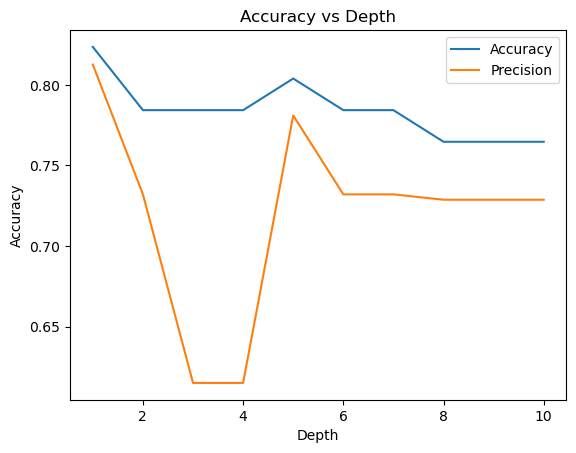

Max Accuracy: 0.8235294117647058, Corresponding Depth: 1
0


In [356]:
import matplotlib.pyplot as plt

accuracies = []
precision = []
depths = range(1, depth+1)
for d in depths:
    decision_tree_classifier = DecisionTreeClassifier(max_depth=d, random_state=42)
    decision_tree_classifier.fit(X_train, y_train_df['Cluster'])

    y_test_pred_rf = decision_tree_classifier.predict(X_test)
    acc = accuracy_score(y_test_df['Cluster'], y_test_pred_rf)
    pre = precision_score(y_test_df['Cluster'], y_test_pred_rf, average='weighted')
    accuracies.append(acc)
    precision.append(pre)

plt.plot(depths, accuracies, label='Accuracy')
plt.plot(depths, precision, label='Precision')
plt.xlabel('Depth')
plt.legend()
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Depth')
plt.show()
max_accuracy = max(accuracies)
max_depth = accuracies.index(max_accuracy) + 1
print(f"Max Accuracy: {max_accuracy}, Corresponding Depth: {max_depth}")
print(accuracies.index(max(accuracies)))

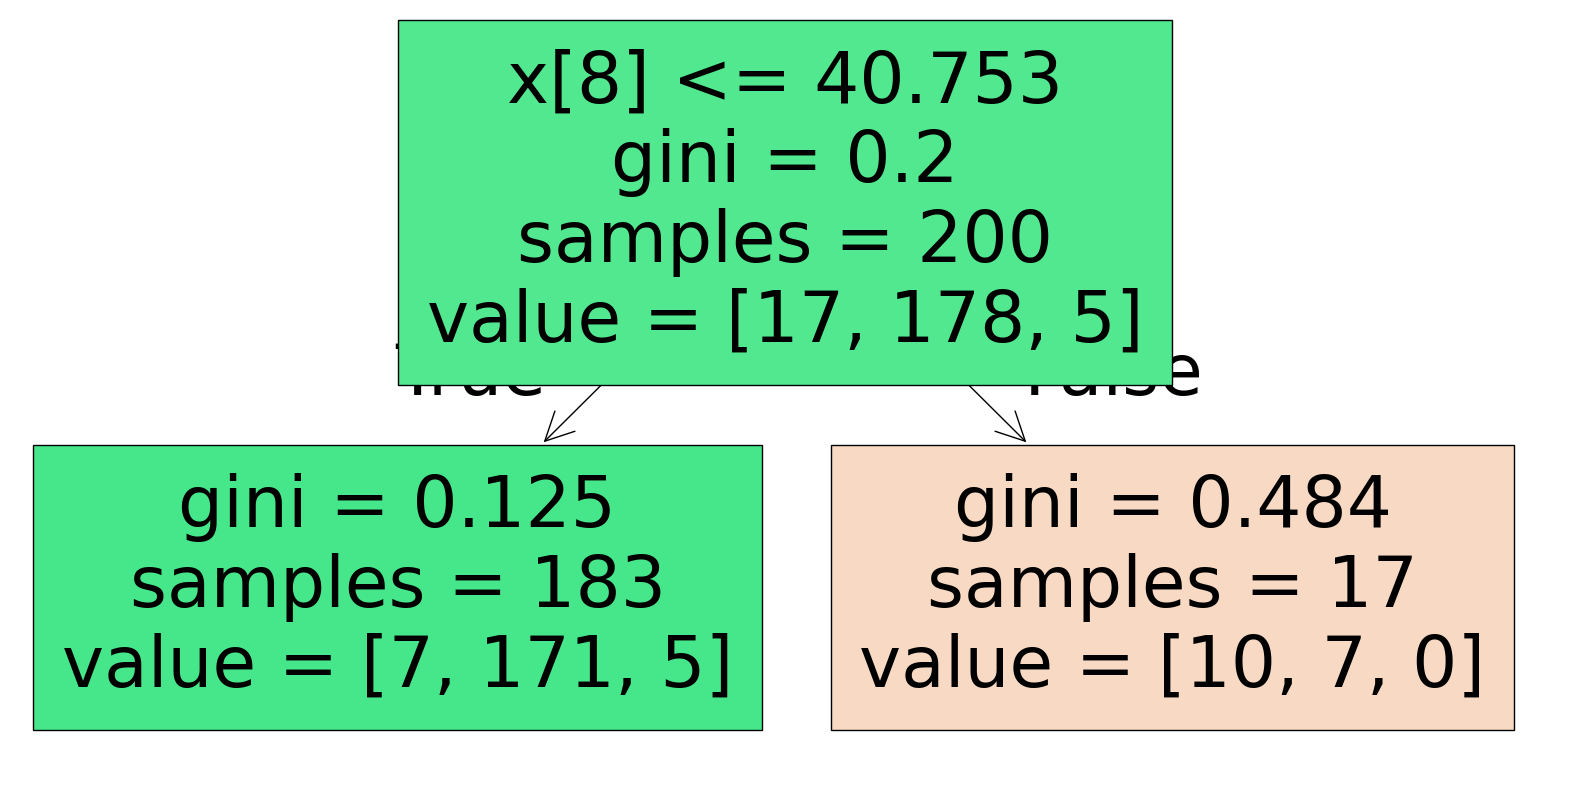

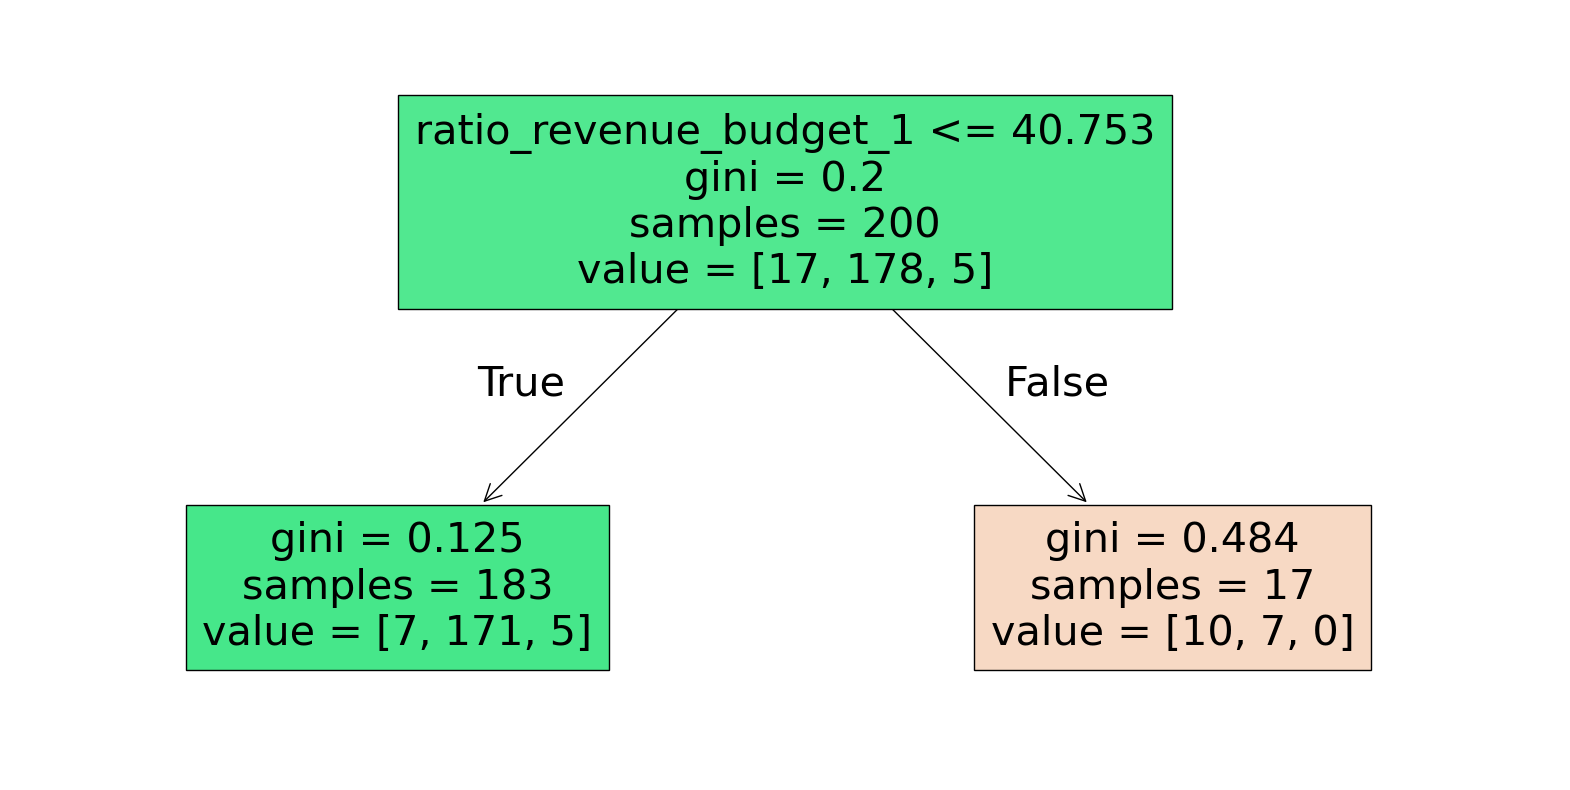

In [350]:

decision_tree_classifier_depth_2 = DecisionTreeClassifier(max_depth=1, random_state=42)
decision_tree_classifier_depth_2.fit(X_train, y_train_df['Cluster'])

plt.figure(figsize=(20, 10))
plot_tree(decision_tree_classifier_depth_2, filled=True)
plt.show()
plt.figure(figsize=(20, 10))
plot_tree(decision_tree_classifier_depth_2, feature_names=X.columns, filled=True)
plt.show()


Leaf Node 1:
Corresponding Cluster: [-1 -1  0  1  1  0  1  1  0  1  1  1  1  1  1  1  1  1  0  1  0  1  1  1
  1  1  1  1  0  1  0 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 -1  1  1  1  1  1  0  1  0  1  1 -1  1  1  1 -1 -1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
 ['Indiana Jones and the Temple of Doom'
 'The Lord of the Rings: The Two Towers' 'Star Trek II: The Wrath of Khan'
 'The Dark Knight' "Ocean's Twelve" 'The Lost World: Jurassic Park'
 'Spider-Man 2' 'Blade II' 'Austin Powers: The Spy Who Shagged Me'
 'Die Hard 2' 'Teenage Mutant Ninja Turtles II: The Secret of the Ooze'
 'The Legend of Zorro' 'Manderlay' 'The Grudge 2' 'Shrek 2'
 'The Matrix Reloaded' 

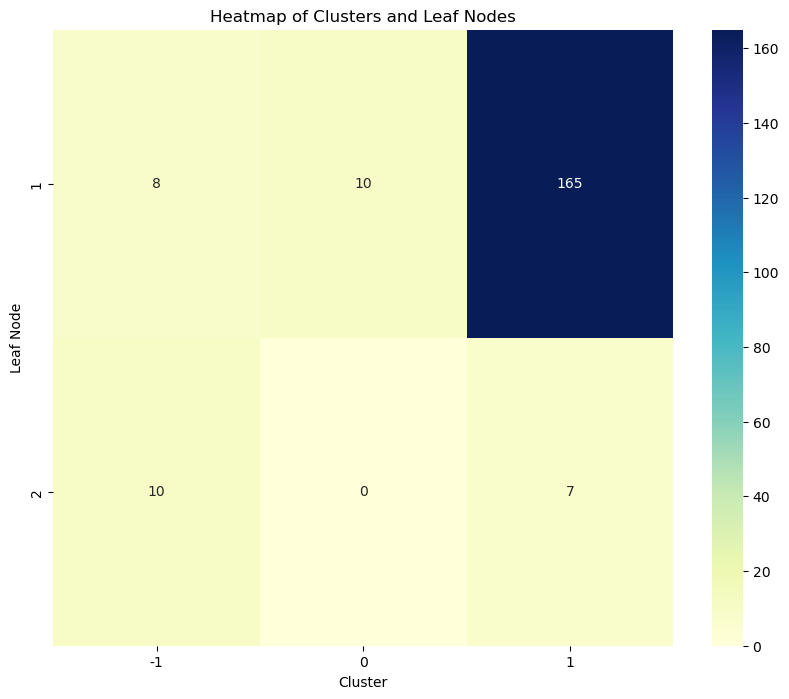

ValueError: All arrays must be of the same length

In [385]:
import seaborn as sns

# Predict which leaf node each sample in the training data belongs to
leaf_nodes = decision_tree_classifier_depth_2.apply(X_train)

# Group samples by leaf node
leaf_data = {leaf: X_train[leaf_nodes == leaf] for leaf in np.unique(leaf_nodes)}

# Access data in each leaf node
for leaf, data in leaf_data.items():
    print(f"Leaf Node {leaf}:")
    #print(data)
    print(f"Corresponding Cluster: {Y[Y.index.isin(data.index)]['Cluster'].values}\n {Y[Y.index.isin(data.index)]['Movie name_2'].values}")
    # Create a heatmap for the clusters and leaf nodes
    leaf_cluster_data = pd.DataFrame({
        'Leaf Node': leaf_nodes,
        'Cluster': y_train['Cluster']
    })

    # Create a pivot table for the heatmap
    heatmap_data = leaf_cluster_data.pivot_table(index='Leaf Node', columns='Cluster', aggfunc='size', fill_value=0)

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlGnBu")
    plt.title('Heatmap of Clusters and Leaf Nodes')
    plt.xlabel('Cluster')
    plt.ylabel('Leaf Node')
    plt.show()
    
    # Create a heatmap for the features and leaf nodes
    leaf_feature_data = pd.DataFrame({
        'Leaf Node': leaf_nodes,
        'Feature': X_train.columns,
    })

    # Create a pivot table for the heatmap
    heatmap_feature_data = leaf_feature_data.pivot_table(index='Leaf Node', columns='Feature', aggfunc='size', fill_value=0)

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_feature_data, annot=True, fmt="d", cmap="YlGnBu")
    plt.title('Heatmap of Features and Leaf Nodes')
    plt.xlabel('Feature')
    plt.ylabel('Leaf Node')
    plt.show()

In [ ]:
# Filter the training data for cluster -1
cluster_minus_1_train = y_train_df[y_train_df['Cluster'] == -1]
print("Training data points in cluster -1:")
print(cluster_minus_1_train)

print(len(cluster_minus_1_train))


In [ ]:

# Filter the training data for cluster 0
cluster_minus_0_train = y_train_df[y_train_df['Cluster'] == 0]
print("Training data points in cluster 0:")
print(cluster_minus_0_train)

print(len(cluster_minus_0_train))